In [1]:
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import statsmodels.api as sm
from os import path
from datetime import timedelta
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
def MAPE(y_true, y_pred): 
    y_true += 1
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [3]:
full_df = pd.read_pickle('new_full_task2.pkl')
test_df = full_df['2016-10-18':]

FileNotFoundError: [Errno 2] No such file or directory: 'new_full_task2.pkl'

In [144]:
results = {}
forecast = {}
tds = ["T1D0", "T1D1", "T2D0", "T3D0", "T3D1"]
# tds = ["T1D0","T1D1"]#,'T2D0','T3D0']
# output_template = "Weather-SARIMAX-3-0-0--1-0-1--72[%s].pkl"
# output_template = "New-Weather-SARIMAX-6-0-1--1-0-1--72[%s].pkl"
# output_template = "Weather-SARIMAX-6-0-1--1-0-1--72[%s].pkl"
output_template = "Peak-Weather-SARIMAX-6-0-1--1-0-1--72[%s].pkl"
# output_template = "New-Weather-SARIMAX-3-0-1--1-0-1--72[%s].pkl"

for td in tds:
    results[td] = pickle.load(
        open(path.join("model", output_template % (td)), 'rb'))
    print(results[td].summary())
    forecast[td] = results[td].predict(0, len(full_df) - 1)
    forecast[td] = forecast[td].map(lambda x: np.round(np.exp(x) - 1, 2))

/usr/local/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


                                 Statespace Model Results                                 
Dep. Variable:                               T1D0   No. Observations:                 2592
Model:             SARIMAX(6, 0, 1)x(1, 0, 1, 72)   Log Likelihood                -646.915
Date:                            Sat, 15 Apr 2017   AIC                           1339.830
Time:                                    19:49:08   BIC                           1474.615
Sample:                                09-19-2016   HQIC                          1388.674
                                     - 10-24-2016                                         
Covariance Type:                              opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
BeforeNationalDay         1.6024      0.222      7.204      0.000       1.166       2.038
Na

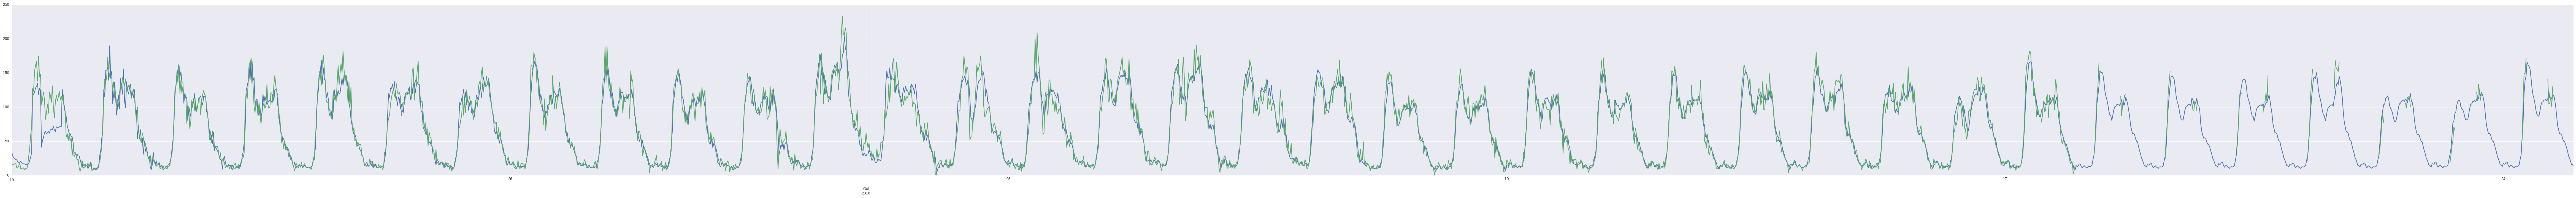

In [145]:
forecast['T3D0'].plot(figsize=(120,8))
full_df['T3D0'].plot()

In [152]:
res = results['T1D0']

In [183]:
res.conf_int().T.mean().round(4)

BeforeNationalDay        1.6024
NationalDayFront(1-4)    1.8490
NationalDayTail(5-7)     1.7948
Weekend                  0.7900
WorkingDay               0.6943
WorkingWeekend           0.1880
HeavyRain               -0.0136
LightRain                0.0195
Rain                    -0.0451
Sunny                    0.0504
EarlyPeakTrafficTime     2.6583
LatePeakTrafficTime      2.3250
NormalTrafficTime        1.9355
ar.L1                    0.3967
ar.L2                    0.1612
ar.L3                    0.1140
ar.L4                    0.0316
ar.L5                    0.0625
ar.L6                    0.0535
ma.L1                   -0.0088
ar.S.L72                 0.9891
ma.S.L72                -1.0470
sigma2                   0.0910
dtype: float64

In [186]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [194]:
lr.coef_

AttributeError: 'LinearRegression' object has no attribute 'coef_'

In [191]:
?lr.set_params

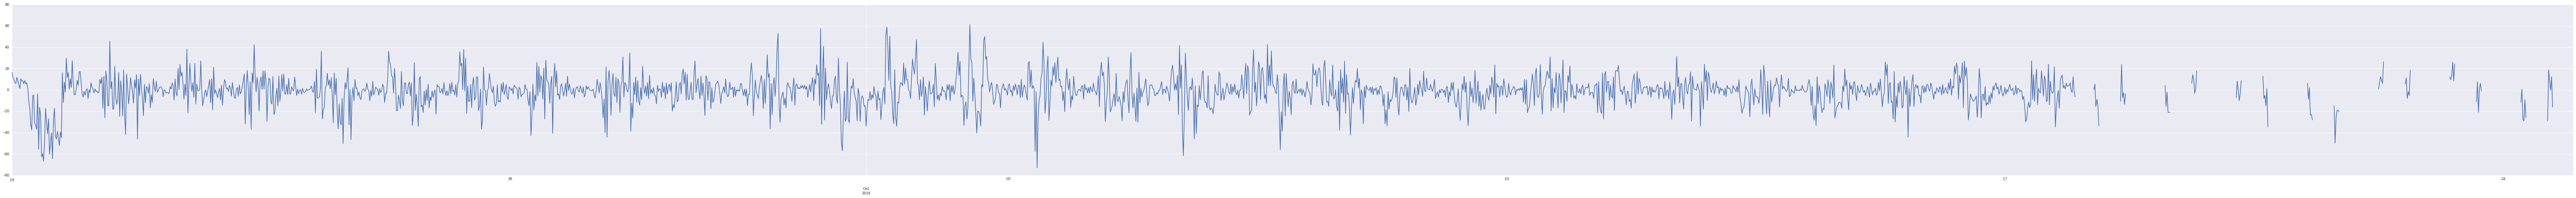

In [149]:
(forecast['T3D0'] - full_df['T3D0']).plot(figsize=(120,8))

In [121]:
forecast_df = pd.DataFrame(forecast)['2016-10-18':]

In [122]:
forecast_df.head()

,T1D0,T1D1,T2D0,T3D0,T3D1
2016-10-18 00:00:00,5.06,92.31,6.87,14.14,126.79
2016-10-18 00:20:00,5.18,56.44,5.00,12.61,101.34
2016-10-18 00:40:00,4.14,36.95,4.28,13.98,80.44
2016-10-18 01:00:00,3.63,6.66,3.04,16.44,10.48
2016-10-18 01:20:00,4.28,7.58,3.19,16.63,9.89


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f94cd609f98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f94cd583978>], dtype=object)

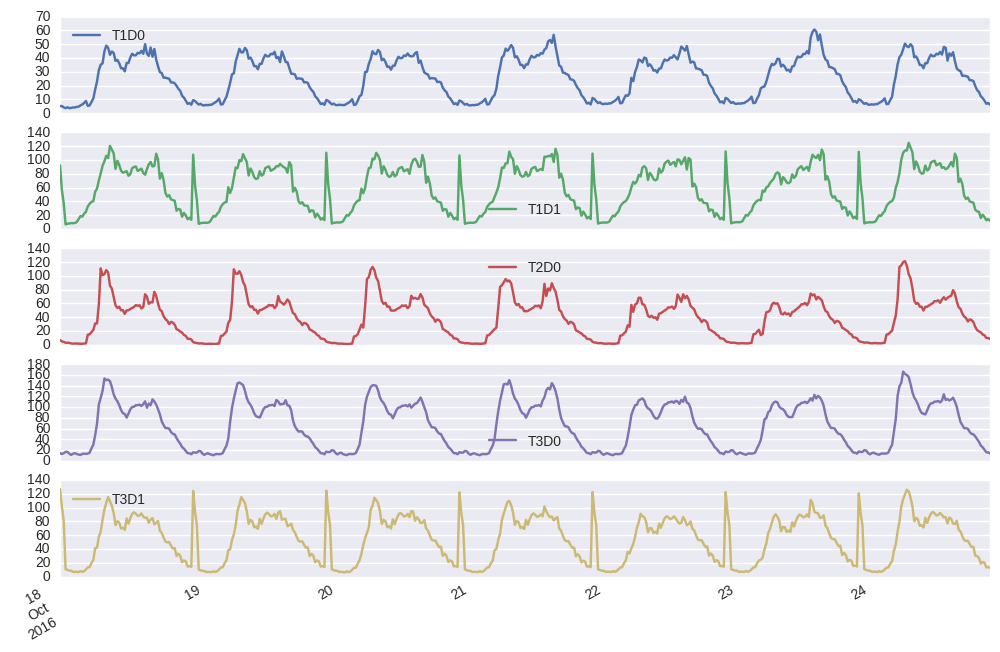

In [123]:
forecast_df.plot(figsize=(12, 8),subplots=True)

In [79]:
def get_timewindow(start_time):
    end_time = start_time.to_pydatetime() + timedelta(0, 20 * 60)
    start_time_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
    end_time_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
    return "[%s,%s)" % (start_time_str, end_time_str)

In [124]:
submit = pd.DataFrame(forecast_df)
submit = pd.concat([
    submit.between_time("17:00", "18:40"), submit.between_time("8:00", "9:40")
]).sort_index()
submit['time_window'] = submit.index.map(get_timewindow)

In [125]:
submit = pd.melt(
    submit,
    var_name='tollgate_id',
    value_name="volume",
    id_vars=['time_window'])

submit["direction"] = submit["tollgate_id"].map(lambda t: int(t[3]))
submit["tollgate_id"] = submit["tollgate_id"].map(lambda t: int(t[1]))

In [126]:
len(submit)

420

In [127]:
submit.head()

,time_window,tollgate_id,volume,direction
0,"[2016-10-18 08:00:00,2016-10-18 08:20:00)",1,44.84,0
1,"[2016-10-18 08:20:00,2016-10-18 08:40:00)",1,48.93,0
2,"[2016-10-18 08:40:00,2016-10-18 09:00:00)",1,47.48,0
3,"[2016-10-18 09:00:00,2016-10-18 09:20:00)",1,42.29,0
4,"[2016-10-18 09:20:00,2016-10-18 09:40:00)",1,44.71,0


In [84]:
submit.to_csv(
    path.join("model", "New-Weather-SARIMAX-6-0-1--1-0-1--72.csv"),
    columns=['tollgate_id', 'time_window', 'direction', 'volume'],
    index=False)